<a href="https://colab.research.google.com/github/let-aranha/tcc-bi-master/blob/main/Classifica%C3%A7%C3%A3o_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/My Drive/TCC/Sample'
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
# Importando json file direto para o notebook

import json 
import pandas as pd
import numpy as np

# Opening JSON file 
f = open('Data_Tickets_V2.json', encoding='utf-8') 

# returns JSON object as 
# a dictionary 
data = json.load(f) 

# Iterating through the json 
# list 
for i in data: 
	print(i) 

# Closing file 
f.close() 

In [3]:
# Convertendo dados em DataFrame

tickets = pd.DataFrame(data)
tickets.head()

,id,external_id,created_at,updated_at,type,subject,raw_subject,description,priority,status,requester_id,submitter_id,assignee_id,organization_id,group_id,collaborator_ids,follower_ids,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,custom_fields,satisfaction_rating,sharing_agreement_ids,fields,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments
0,135697,None,2019-01-04T16:32:37Z,2020-09-15T21:57:09Z,task,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",normal,closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,"[116064848052, 1107926788]","[116064848052, 1107926788]",None,NaN,False,True,None,"[checkout_api, closed_by_admin, complexity__mo...","[{'id': 360020624211, 'value': 'other'}, {'id'...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'other'}, {'id'...",[],148248,144968,None,False,True
1,157508,None,2019-05-03T15:14:09Z,2020-09-25T16:04:36Z,question,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",high,closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,"[364759608791, 385963764891]","[364759608791, 385963764891]",None,NaN,False,True,None,"[bra-pod-cx4, complexity__moderate, defcon-low...","[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True
2,162875,child_of_286591,2019-05-29T11:47:31Z,2020-12-28T22:24:01Z,incident,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,high,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,[364759608791],[364759608791],None,290135.0,False,True,None,"[bra-pod-cx4, complexity__high, defcon-low, fi...","[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True
3,163638,child_of_280741,2019-06-03T12:44:35Z,2020-10-19T15:05:12Z,question,Raio de apresentação dos Pontos de retirada (P...,Raio de apresentação dos Pontos de retirada (P...,"Olá,\n\nComo trabalhamos com consultoras (B2B)...",high,closed,8958433768,8958433768,1.107927e+09,1.411849e+10,360007523311,[],[],None,NaN,False,True,None,"[bra-pod-cx4, complexity__moderate, defcon-low...","[{'id': 360020624211, 'value': 'xp_post_purcha...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_post_purcha...",[],148248,144968,None,False,True
4,166035,child_of_285286,2019-06-12T15:23:14Z,2020-12-28T21:32:50Z,incident,Alteração de itens pedido no OMS do White Labe...,Alteração de itens pedido no OMS do White Labe...,*O mesmo ocorre nos White Labels do ambiente p...,high,hold,8958433768,8958433768,3.793557e+11,3.601459e+11,360013871732,"[364759608791, 379355684012, 385963764891]","[364759608791, 379355684012, 385963764891]",None,NaN,False,True,None,"[bra-pod-cx4, complexity__very_high, defcon-lo...","[{'id': 360020624211, 'value': ''}, {'id': 360...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': ''}, {'id': 360...",[],148248,144968,None,False,True


In [4]:
tickets.set_index('id', inplace = True)
tickets.head(2)

,external_id,created_at,updated_at,type,subject,raw_subject,description,priority,status,requester_id,submitter_id,assignee_id,organization_id,group_id,collaborator_ids,follower_ids,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,custom_fields,satisfaction_rating,sharing_agreement_ids,fields,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135697,None,2019-01-04T16:32:37Z,2020-09-15T21:57:09Z,task,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",normal,closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,"[116064848052, 1107926788]","[116064848052, 1107926788]",None,NaN,False,True,None,"[checkout_api, closed_by_admin, complexity__mo...","[{'id': 360020624211, 'value': 'other'}, {'id'...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'other'}, {'id'...",[],148248,144968,None,False,True
157508,None,2019-05-03T15:14:09Z,2020-09-25T16:04:36Z,question,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",high,closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,"[364759608791, 385963764891]","[364759608791, 385963764891]",None,NaN,False,True,None,"[bra-pod-cx4, complexity__moderate, defcon-low...","[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True


In [5]:
# Tratando colunas "collaborator_ids" para que mostre os totais e não os ids
collaborators = []

for i in tickets['collaborator_ids']:
    collaborators.append(len(i))

tickets['collaborators'] = collaborators
tickets.head()

,external_id,created_at,updated_at,type,subject,raw_subject,description,priority,status,requester_id,submitter_id,assignee_id,organization_id,group_id,collaborator_ids,follower_ids,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,custom_fields,satisfaction_rating,sharing_agreement_ids,fields,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments,collaborators
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135697,None,2019-01-04T16:32:37Z,2020-09-15T21:57:09Z,task,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",normal,closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,"[116064848052, 1107926788]","[116064848052, 1107926788]",None,NaN,False,True,None,"[checkout_api, closed_by_admin, complexity__mo...","[{'id': 360020624211, 'value': 'other'}, {'id'...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'other'}, {'id'...",[],148248,144968,None,False,True,2
157508,None,2019-05-03T15:14:09Z,2020-09-25T16:04:36Z,question,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",high,closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,"[364759608791, 385963764891]","[364759608791, 385963764891]",None,NaN,False,True,None,"[bra-pod-cx4, complexity__moderate, defcon-low...","[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,2
162875,child_of_286591,2019-05-29T11:47:31Z,2020-12-28T22:24:01Z,incident,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,high,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,[364759608791],[364759608791],None,290135.0,False,True,None,"[bra-pod-cx4, complexity__high, defcon-low, fi...","[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,1
163638,child_of_280741,2019-06-03T12:44:35Z,2020-10-19T15:05:12Z,question,Raio de apresentação dos Pontos de retirada (P...,Raio de apresentação dos Pontos de retirada (P...,"Olá,\n\nComo trabalhamos com consultoras (B2B)...",high,closed,8958433768,8958433768,1.107927e+09,1.411849e+10,360007523311,[],[],None,NaN,False,True,None,"[bra-pod-cx4, complexity__moderate, defcon-low...","[{'id': 360020624211, 'value': 'xp_post_purcha...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_post_purcha...",[],148248,144968,None,False,True,0
166035,child_of_285286,2019-06-12T15:23:14Z,2020-12-28T21:32:50Z,incident,Alteração de itens pedido no OMS do White Labe...,Alteração de itens pedido no OMS do White Labe...,*O mesmo ocorre nos White Labels do ambiente p...,high,hold,8958433768,8958433768,3.793557e+11,3.601459e+11,360013871732,"[364759608791, 379355684012, 385963764891]","[364759608791, 379355684012, 385963764891]",None,NaN,False,True,None,"[bra-pod-cx4, complexity__very_high, defcon-lo...","[{'id': 360020624211, 'value': ''}, {'id': 360...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': ''}, {'id': 360...",[],148248,144968,None,False,True,3


In [6]:
# Descartando colunas "collaborator_ids" e "follower_ids"
# OBS: coluna "follower_ids" é idêntica à "collaborator_ids"
tickets = tickets.drop(['collaborator_ids','follower_ids'], axis=1)

In [7]:
# Tratando coluna 'tags' para que mostre o total de tags para cada ticket

tags = []

for t in tickets['tags']:
    tags.append(len(t))

tickets['tags'] = tags
tickets['tags'].head()

id
135697    25
157508    16
162875    21
163638    17
166035    16
Name: tags, dtype: int64

In [8]:
# Tratando colunas de datas

import re

# Retirando valores referentes à hora para a coluna created_at
tickets.loc[:,'created_at'].replace({"T.*Z": ''}, regex=True, inplace=True)

# Retirando valores referentes à hora para a coluna updated_at
tickets.loc[:,'updated_at'].replace({"T.*Z": ''}, regex=True, inplace=True)

tickets.head()

,external_id,created_at,updated_at,type,subject,raw_subject,description,priority,status,requester_id,submitter_id,assignee_id,organization_id,group_id,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,custom_fields,satisfaction_rating,sharing_agreement_ids,fields,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments,collaborators
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135697,None,2019-01-04,2020-09-15,task,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",normal,closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,None,NaN,False,True,None,25,"[{'id': 360020624211, 'value': 'other'}, {'id'...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'other'}, {'id'...",[],148248,144968,None,False,True,2
157508,None,2019-05-03,2020-09-25,question,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",high,closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,NaN,False,True,None,16,"[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,2
162875,child_of_286591,2019-05-29,2020-12-28,incident,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,high,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,290135.0,False,True,None,21,"[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,1
163638,child_of_280741,2019-06-03,2020-10-19,question,Raio de apresentação dos Pontos de retirada (P...,Raio de apresentação dos Pontos de retirada (P...,"Olá,\n\nComo trabalhamos com consultoras (B2B)...",high,closed,8958433768,8958433768,1.107927e+09,1.411849e+10,360007523311,None,NaN,False,True,None,17,"[{'id': 360020624211, 'value': 'xp_post_purcha...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_post_purcha...",[],148248,144968,None,False,True,0
166035,child_of_285286,2019-06-12,2020-12-28,incident,Alteração de itens pedido no OMS do White Labe...,Alteração de itens pedido no OMS do White Labe...,*O mesmo ocorre nos White Labels do ambiente p...,high,hold,8958433768,8958433768,3.793557e+11,3.601459e+11,360013871732,None,NaN,False,True,None,16,"[{'id': 360020624211, 'value': ''}, {'id': 360...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': ''}, {'id': 360...",[],148248,144968,None,False,True,3


In [9]:
# Criando dados de duração do ticket
from datetime import datetime

created = []
for i in tickets['created_at']:
    created.append(datetime.strptime(i, '%Y-%m-%d').date())

updated = []
for i in tickets['updated_at']:
    updated.append(datetime.strptime(i, '%Y-%m-%d').date())
    
duration_days = []
for i in range(len(created)):
    duration_days.append((updated[i]-created[i]).days)

In [10]:
# Incluindo nova coluna ao DataFrame com dados de duração dos tickets
tickets['duration_days'] = duration_days
tickets.head()

,external_id,created_at,updated_at,type,subject,raw_subject,description,priority,status,requester_id,submitter_id,assignee_id,organization_id,group_id,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,custom_fields,satisfaction_rating,sharing_agreement_ids,fields,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments,collaborators,duration_days
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135697,None,2019-01-04,2020-09-15,task,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",normal,closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,None,NaN,False,True,None,25,"[{'id': 360020624211, 'value': 'other'}, {'id'...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'other'}, {'id'...",[],148248,144968,None,False,True,2,620
157508,None,2019-05-03,2020-09-25,question,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",high,closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,NaN,False,True,None,16,"[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,2,511
162875,child_of_286591,2019-05-29,2020-12-28,incident,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,high,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,290135.0,False,True,None,21,"[{'id': 360020624211, 'value': 'xp_merch__cata...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,1,579
163638,child_of_280741,2019-06-03,2020-10-19,question,Raio de apresentação dos Pontos de retirada (P...,Raio de apresentação dos Pontos de retirada (P...,"Olá,\n\nComo trabalhamos com consultoras (B2B)...",high,closed,8958433768,8958433768,1.107927e+09,1.411849e+10,360007523311,None,NaN,False,True,None,17,"[{'id': 360020624211, 'value': 'xp_post_purcha...",{'score': 'offered'},[],"[{'id': 360020624211, 'value': 'xp_post_purcha...",[],148248,144968,None,False,True,0,504
166035,child_of_285286,2019-06-12,2020-12-28,incident,Alteração de itens pedido no OMS do White Labe...,Alteração de itens pedido no OMS do White Labe...,*O mesmo ocorre nos White Labels do ambiente p...,high,hold,8958433768,8958433768,3.793557e+11,3.601459e+11,360013871732,None,NaN,False,True,None,16,"[{'id': 360020624211, 'value': ''}, {'id': 360...",{'score': 'unoffered'},[],"[{'id': 360020624211, 'value': ''}, {'id': 360...",[],148248,144968,None,False,True,3,565


In [11]:
satisfaction = []

for i in tickets['satisfaction_rating']:
    satisfaction.append(i['score'])
    
tickets['satisfaction_rating'] = satisfaction
tickets['satisfaction_rating'].head()

id
135697      offered
157508      offered
162875    unoffered
163638      offered
166035    unoffered
Name: satisfaction_rating, dtype: object

In [12]:
# None = 0
# Se tiver external_id = 1

has_external_id = []

for i in tickets['external_id']:
    if i != None:
        has_external_id.append(1)
    else:
        has_external_id.append(0)
        
tickets['external_id'] = has_external_id   
tickets['external_id'].head()

id
135697    0
157508    0
162875    1
163638    1
166035    1
Name: external_id, dtype: int64

In [13]:
tickets['type'].unique()

array(['task', 'question', 'incident', None], dtype=object)

In [14]:
# Transformando variável categórica com One Hot Encoding
types = pd.get_dummies(tickets.type, prefix = 'type', drop_first = True)
types.head()

,type_question,type_task
id,,
135697,0,1
157508,1,0
162875,0,0
163638,1,0
166035,0,0


In [15]:
tickets.priority.unique()

array(['normal', 'high', 'low', 'urgent'], dtype=object)

In [16]:
# Transformando variável categórica com One Hot Encoding
priorities = pd.get_dummies(tickets.priority, prefix = 'priority', drop_first = True)
priorities.head()

,priority_low,priority_normal,priority_urgent
id,,,
135697,0,1,0
157508,0,0,0
162875,0,0,0
163638,0,0,0
166035,0,0,0


In [17]:
# Dando merge nos DataFrames e excluindo as variáveis originais
frames = [tickets,types,priorities]
tickets = pd.concat(frames,axis=1)
tickets = tickets.drop(['priority','type'], axis=1)
tickets.head()

,external_id,created_at,updated_at,subject,raw_subject,description,status,requester_id,submitter_id,assignee_id,organization_id,group_id,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,custom_fields,satisfaction_rating,sharing_agreement_ids,fields,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments,collaborators,duration_days,type_question,type_task,priority_low,priority_normal,priority_urgent
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135697,0,2019-01-04,2020-09-15,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,None,NaN,False,True,None,25,"[{'id': 360020624211, 'value': 'other'}, {'id'...",offered,[],"[{'id': 360020624211, 'value': 'other'}, {'id'...",[],148248,144968,None,False,True,2,620,0,1,0,1,0
157508,0,2019-05-03,2020-09-25,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,NaN,False,True,None,16,"[{'id': 360020624211, 'value': 'xp_merch__cata...",offered,[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,2,511,1,0,0,0,0
162875,1,2019-05-29,2020-12-28,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,290135.0,False,True,None,21,"[{'id': 360020624211, 'value': 'xp_merch__cata...",unoffered,[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,1,579,0,0,0,0,0
163638,1,2019-06-03,2020-10-19,Raio de apresentação dos Pontos de retirada (P...,Raio de apresentação dos Pontos de retirada (P...,"Olá,\n\nComo trabalhamos com consultoras (B2B)...",closed,8958433768,8958433768,1.107927e+09,1.411849e+10,360007523311,None,NaN,False,True,None,17,"[{'id': 360020624211, 'value': 'xp_post_purcha...",offered,[],"[{'id': 360020624211, 'value': 'xp_post_purcha...",[],148248,144968,None,False,True,0,504,1,0,0,0,0
166035,1,2019-06-12,2020-12-28,Alteração de itens pedido no OMS do White Labe...,Alteração de itens pedido no OMS do White Labe...,*O mesmo ocorre nos White Labels do ambiente p...,hold,8958433768,8958433768,3.793557e+11,3.601459e+11,360013871732,None,NaN,False,True,None,16,"[{'id': 360020624211, 'value': ''}, {'id': 360...",unoffered,[],"[{'id': 360020624211, 'value': ''}, {'id': 360...",[],148248,144968,None,False,True,3,565,0,0,0,0,0


# Separando dados da coluna 'custom_fields' em novas variáveis

In [18]:
# Validando que colunas "fields" e "custom_fields" são identicas

x = tickets['fields'] == tickets['custom_fields']
x.unique()

array([ True])

In [19]:
# Excluindo coluna "custom_fields"
tickets = tickets.drop(['custom_fields'], axis=1)

In [43]:
# Laço para separar valores no campo 'fields' e inseri-los no DataFrame como variáveis distintas
valores = []
contador = 0

while contador < 32:
    for i in tickets.iloc[:,20]:
        valores.append(i[contador]['value'])
    tickets[str(tickets.iloc[0,20][contador]['id'])] = valores
    contador += 1
    del valores[:]
        
tickets.head()

,external_id,created_at,updated_at,subject,raw_subject,description,status,requester_id,submitter_id,assignee_id,organization_id,group_id,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,satisfaction_rating,sharing_agreement_ids,fields,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments,collaborators,duration_days,type_question,type_task,priority_low,priority_normal,priority_urgent,360020624211,360020624491,360020569452,25474137,360033914632,360033911051,360035835671,360028303391,360027863592,360032744491,360027865132,360027864112,360032705332,360027926331,360037125691,360032708932,360034881612,360037124431,360032708452,360035887992,360032744571,360027924871,360032711312,360032642972,360035892392,360034057912,360035575491,360034810312,360035892432,360033911251,360038367451,360027863792
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135697,0,2019-01-04,2020-09-15,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,None,NaN,False,True,None,25,offered,[],"[{'id': 360020624211, 'value': 'other'}, {'id'...",[],148248,144968,None,False,True,2,620,0,1,0,1,0,other,"[resources_used__help_center, resources_used__...",complexity__moderate,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,?,None,None,None,None,None,None
157508,0,2019-05-03,2020-09-25,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,NaN,False,True,None,16,offered,[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,2,511,1,0,0,0,0,xp_merch__catalog,[resources_used__my_own_knowledge],complexity__moderate,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
162875,1,2019-05-29,2020-12-28,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,290135.0,False,True,None,21,unoffered,[],"[{'id': 360020624211, 'value': 'xp_merch__cata...",[],148248,144968,None,False,True,1,579,0,0,0,0,0,xp_merch__catalog__catalog_indexer,[resources_used__xp_issue],complexity__high,,None,None,None,28,None,impact_post_purchase_moderate,None,None,None,None,None,impact_security_no,None,None,impact_conversion_moderate,None,impact_productivity_moderate,None,impact_gmv_moderate,None,None,None,None,None,None,None,None,None
163638,1,2019-06-03,2020-10-19,Raio de apresentação dos Pontos de retirada (P...,Raio de apresentação dos Pontos de retirada (P...,"Olá,\n\nComo trabalhamos com consultoras (B2B)...",closed,8958433768,8958433768,1.107927e+09,1.411849e+10,360007523311,None,NaN,False,True,None,17,offered,[],"[{'id': 360020624211, 'value': 'xp_post_purcha...",[],148248,144968,None,False,True,0,504,1,0,0,0,0,xp_post_purchase__logistics__pickup_points,[resources_used__someone_knowledge_xp],complexity__moderate,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
166035,1,2019-06-12,2020-12-28,Alteração de itens pedido no OMS do White Labe...,Alteração de itens pedido no OMS do White Labe...,*O mesmo ocorre nos White Labels do ambiente p...,hold,8958433768,8958433768,3.793557e+11,3.601459e+11,360013871732,None,NaN,False,True,None,16,unoffered,[],"[{'id': 360020624211, 'value': ''}, {'id': 360...",[],148248,144968,None,False,True,3,565,0,0,0,0,0,,[resources_used__someone_knowledge_xp],complexity__very_high,None,None,None,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,N

In [44]:
# Tratando variável 360020569452 para exclusão de termo 'complexity__'
complexity = []

for i in tickets['360020569452']:
    if i != None:
        complexity.append(i.replace('complexity__', ''))
    else:
        complexity.append(None)

tickets['360020569452'] = complexity
tickets.rename(columns={'360020569452': 'complexity'}, inplace = True)

In [45]:
# Descartando coluna 'fields'
tickets = tickets.drop(['fields'], axis=1)

In [46]:
# Excluindo linhas do DataFrame para quando "is_public" != True
tickets = tickets[tickets['is_public'] == True]
tickets['is_public'].describe()

count       75
unique       1
top       True
freq        75
Name: is_public, dtype: object

# Análise Exploratória

In [48]:
# Importação dos pacotes

import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seed para reprodução de resultados
seed = 1
random.seed(seed)
np.random.seed(seed)

In [49]:
tickets.head()

,external_id,created_at,updated_at,subject,raw_subject,description,status,requester_id,submitter_id,assignee_id,organization_id,group_id,forum_topic_id,problem_id,has_incidents,is_public,due_at,tags,satisfaction_rating,sharing_agreement_ids,followup_ids,ticket_form_id,brand_id,satisfaction_probability,allow_channelback,allow_attachments,collaborators,duration_days,type_question,type_task,priority_low,priority_normal,priority_urgent,360020624211,360020624491,complexity,25474137,360033914632,360033911051,360035835671,360028303391,360027863592,360032744491,360027865132,360027864112,360032705332,360027926331,360037125691,360032708932,360034881612,360037124431,360032708452,360035887992,360032744571,360027924871,360032711312,360032642972,360035892392,360034057912,360035575491,360034810312,360035892432,360033911251,360038367451,360027863792
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135697,0,2019-01-04,2020-09-15,Afiliados - permissões e auditoria,Afiliados - permissões e auditoria,"Paula, boa tarde!\n\nConforme conversamos pelo...",closed,362349778952,368697962711,1.107927e+09,4.280655e+07,360002366212,None,NaN,False,True,None,25,offered,[],[],148248,144968,None,False,True,2,620,0,1,0,1,0,other,"[resources_used__help_center, resources_used__...",moderate,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,?,None,None,None,None,None,None
157508,0,2019-05-03,2020-09-25,"Ordenação de produtos ""esgotados"" na vitrine","Ordenação de produtos ""esgotados"" na vitrine","Olá,\n\nConforme já discutido com Ademir e Rod...",closed,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,NaN,False,True,None,16,offered,[],[],148248,144968,None,False,True,2,511,1,0,0,0,0,xp_merch__catalog,[resources_used__my_own_knowledge],moderate,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
162875,1,2019-05-29,2020-12-28,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,None,290135.0,False,True,None,21,unoffered,[],[],148248,144968,None,False,True,1,579,0,0,0,0,0,xp_merch__catalog__catalog_indexer,[resources_used__xp_issue],high,,None,None,None,28,None,impact_post_purchase_moderate,None,None,None,None,None,impact_security_no,None,None,impact_conversion_moderate,None,impact_productivity_moderate,None,impact_gmv_moderate,None,None,None,None,None,None,None,None,None
163638,1,2019-06-03,2020-10-19,Raio de apresentação dos Pontos de retirada (P...,Raio de apresentação dos Pontos de retirada (P...,"Olá,\n\nComo trabalhamos com consultoras (B2B)...",closed,8958433768,8958433768,1.107927e+09,1.411849e+10,360007523311,None,NaN,False,True,None,17,offered,[],[],148248,144968,None,False,True,0,504,1,0,0,0,0,xp_post_purchase__logistics__pickup_points,[resources_used__someone_knowledge_xp],moderate,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
166035,1,2019-06-12,2020-12-28,Alteração de itens pedido no OMS do White Labe...,Alteração de itens pedido no OMS do White Labe...,*O mesmo ocorre nos White Labels do ambiente p...,hold,8958433768,8958433768,3.793557e+11,3.601459e+11,360013871732,None,NaN,False,True,None,16,unoffered,[],[],148248,144968,None,False,True,3,565,0,0,0,0,0,,[resources_used__someone_knowledge_xp],very_high,None,None,None,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [50]:
# Tamanho da amostra

tickets.shape

(75, 65)

In [51]:
tickets.describe()

,external_id,requester_id,submitter_id,assignee_id,organization_id,group_id,problem_id,tags,ticket_form_id,brand_id,collaborators,duration_days,type_question,type_task,priority_low,priority_normal,priority_urgent
count,75.000000,7.500000e+01,7.500000e+01,7.300000e+01,6.300000e+01,7.500000e+01,3.000000,75.000000,7.500000e+01,75.0,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.133333,2.751985e+11,2.651541e+11,3.470556e+11,1.553322e+11,3.600089e+11,276832.666667,14.773333,2.880018e+10,144968.0,1.706667,337.933333,0.506667,0.026667,0.053333,0.466667,0.093333
std,0.342224,1.573248e+11,1.624654e+11,1.134343e+11,1.662401e+11,3.075562e+06,15176.250338,5.409135,9.832335e+10,0.0,2.064980,100.062998,0.503322,0.162192,0.226210,0.502247,0.292858
min,0.000000,9.171815e+08,8.334616e+08,8.766956e+08,4.153548e+07,3.600003e+11,260302.000000,1.000000,1.482480e+05,144968.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.151281e+11,1.143011e+11,3.772809e+11,1.403343e+08,3.600061e+11,270181.500000,13.000000,1.482480e+05,144968.0,0.000000,278.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.741729e+11,3.720656e+11,3.856002e+11,1.141076e+11,3.600088e+11,280061.000000,16.000000,1.482480e+05,144968.0,1.000000,327.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.847276e+11,3.847276e+11,3.871000e+11,3.600672e+11,3.600120e+11,285098.000000,18.000000,1.482480e+05,144968.0,2.000000,393.500000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,3.923841e+11,3.923841e+11,3.986605e+11,3.606271e+11,3.600139e+11,290135.000000,25.000000,3.600006e+11,144968.0,8.000000,620.000000,1.000000,1.000000,1.000000,1.000000,1.000000


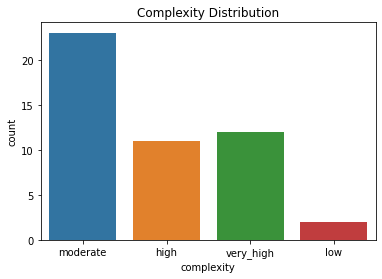

In [52]:
# Análise balanceamento

sns.countplot(data=tickets, x='complexity')
plt.rcParams['figure.figsize'] = (11,7)
plt.title('Complexity Distribution')
plt.show()

In [53]:
# Analisando somatório de valores nulls na base de dados

tickets.isnull().sum()

external_id      0
created_at       0
updated_at       0
subject          0
raw_subject      0
                ..
360034810312    75
360035892432    75
360033911251    75
360038367451    75
360027863792    75
Length: 65, dtype: int64

In [54]:
# Limpando dados nulos da coluna de classificação

tickets = tickets.dropna(subset=['complexity'])

In [55]:
# Validando número de campos nulos na variável categórica

tickets['complexity'].isnull().sum()

0

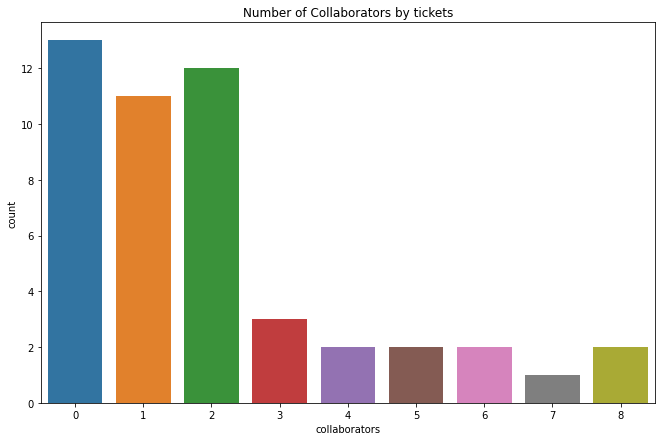

In [56]:
# Plotando gráfico para analisar número de colaboradores por ticket

sns.countplot(data=tickets, x='collaborators')
plt.rcParams['figure.figsize'] = (11,7)
plt.title('Number of Collaborators by tickets')
plt.show()

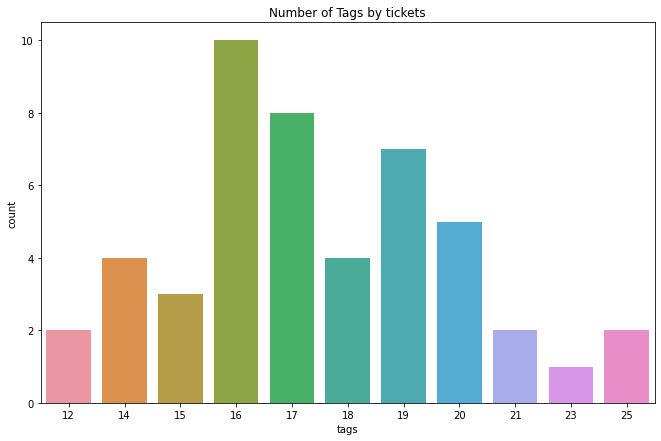

In [57]:
# Plotando gráfico para analisar número de tags por ticket

sns.countplot(data=tickets, x='tags')
plt.rcParams['figure.figsize'] = (11,7)
plt.title('Number of Tags by tickets')
plt.show()

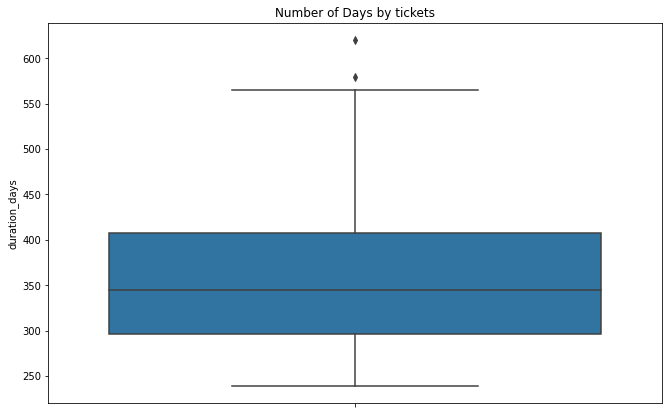

In [58]:
# Plotando boxplot da distribuição do número de dias

sns.boxplot(data=tickets, y='duration_days')
sns.set(style="whitegrid", color_codes=True)
plt.title('Number of Days by tickets')
plt.show()

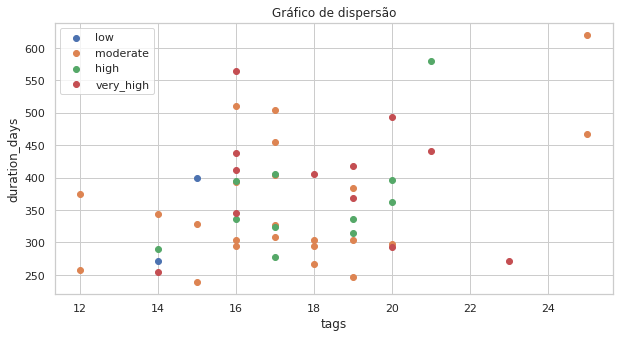

In [59]:
# Gráfico de relação entre duração e número de colaboradores

low = tickets[tickets.complexity == 'low']
moderate = tickets[tickets.complexity == 'moderate']
high = tickets[tickets.complexity == 'high']
very_high = tickets[tickets.complexity == 'very_high']

plt.figure(figsize=(10,5))
plt.scatter(data=low, x='tags', y='duration_days', label='low')
plt.scatter(data=moderate, x='tags', y='duration_days', label='moderate')
plt.scatter(data=high, x='tags', y='duration_days', label='high')
plt.scatter(data=very_high, x='tags', y='duration_days', label='very_high')


plt.xlabel('tags')
plt.ylabel('duration_days')
plt.title('Gráfico de dispersão')

plt.legend()
plt.show()

# Separando Input e Output

In [60]:
# semente para reprodução de resultados
seed=10000

# Separando base de treino e de teste
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tickets.loc[:,tickets.columns != 'complexity'],
                                                    tickets['complexity'], test_size=0.2, stratify=tickets['complexity'],
                                                    random_state=seed)

print('shape input de treino: ', x_train.shape)
print('shape input de teste: ', x_test.shape)
print('shape output de treino: ', y_train.shape)
print('shape output de teste: ', y_test.shape)

shape input de treino:  (38, 64)
shape input de teste:  (10, 64)
shape output de treino:  (38,)
shape output de teste:  (10,)


In [61]:
# Verificar proporções. Amostragem estratificada

tickets['complexity'].value_counts()

moderate     23
very_high    12
high         11
low           2
Name: complexity, dtype: int64

In [62]:
#treino
print(0.8 * tickets['complexity'].value_counts()[0])
print(0.8 * tickets['complexity'].value_counts()[1])

#teste
print(0.2 * tickets['complexity'].value_counts()[0])
print(0.2 * tickets['complexity'].value_counts()[1])

18.400000000000002
9.600000000000001
4.6000000000000005
2.4000000000000004


In [63]:
y_train.value_counts()

moderate     18
very_high     9
high          9
low           2
Name: complexity, dtype: int64

In [64]:
y_test.value_counts()

moderate     5
very_high    3
high         2
Name: complexity, dtype: int64

# Pré-Processamento

In [ ]:
# !pip install missingno

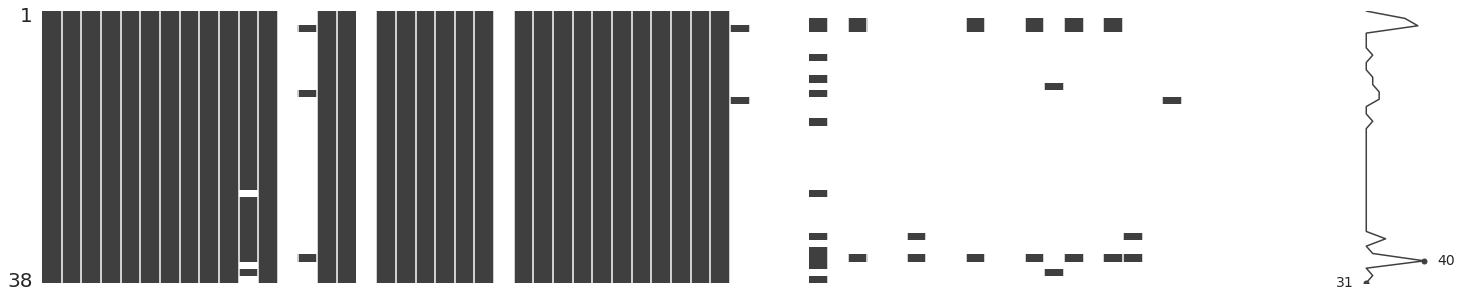

In [66]:
# Visualizar missing

import missingno as msno
msno.matrix(x_train, figsize=(25,5));

In [67]:
# Verificar missing por linha

percent_missing_rows = x_train.apply(lambda x: x.isnull().sum() * 100 / len(x_train), axis=1).sort_values(ascending=False)
df = pd.DataFrame({'row_index': x_train.index, 'percent_missing': percent_missing_rows})
df.head()

,row_index,percent_missing
id,,
205115,210725,86.842105
186468,177936,86.842105
185822,162875,86.842105
200744,185822,86.842105
202098,200744,86.842105


In [68]:
# Verificar missing por coluna

percent_missing = x_train.apply(lambda x: x.isnull().sum() * 100 / len(x_train), axis=0).sort_values(ascending=False)
df = pd.DataFrame({'column_name': x_train.columns, 'percent_missing': percent_missing})
df.head(35)

,column_name,percent_missing
360027863792,external_id,100.000000
360037124431,created_at,100.000000
forum_topic_id,updated_at,100.000000
satisfaction_probability,subject,100.000000
360038367451,raw_subject,100.000000
360033914632,description,100.000000
360033911051,status,100.000000
360035835671,requester_id,100.000000
due_at,submitter_id,100.000000
360027865132,assignee_id,100.000000


In [69]:
# Classe tem missing?

y_train.isnull().sum()

0

In [70]:
# Atributos com muitos missing serão deletados

att_to_delete = df[0:32].index.values
att_to_delete

array(['360027863792', '360037124431', 'forum_topic_id',
       'satisfaction_probability', '360038367451', '360033914632',
       '360033911051', '360035835671', 'due_at', '360027865132',
       '360027864112', '360027926331', '360037125691', '360034881612',
       '360027863592', '360035892432', '360027924871', '360033911251',
       '360034810312', '360035892392', '360035575491', '360034057912',
       '25474137', '360035887992', '360032705332', '360032642972',
       'problem_id', '360032708932', '360032708452', '360032744491',
       '360032711312', '360032744571'], dtype=object)

In [71]:
# Deletar atributos

x_train.drop(att_to_delete, axis=1, inplace=True)
x_train.shape

(38, 32)

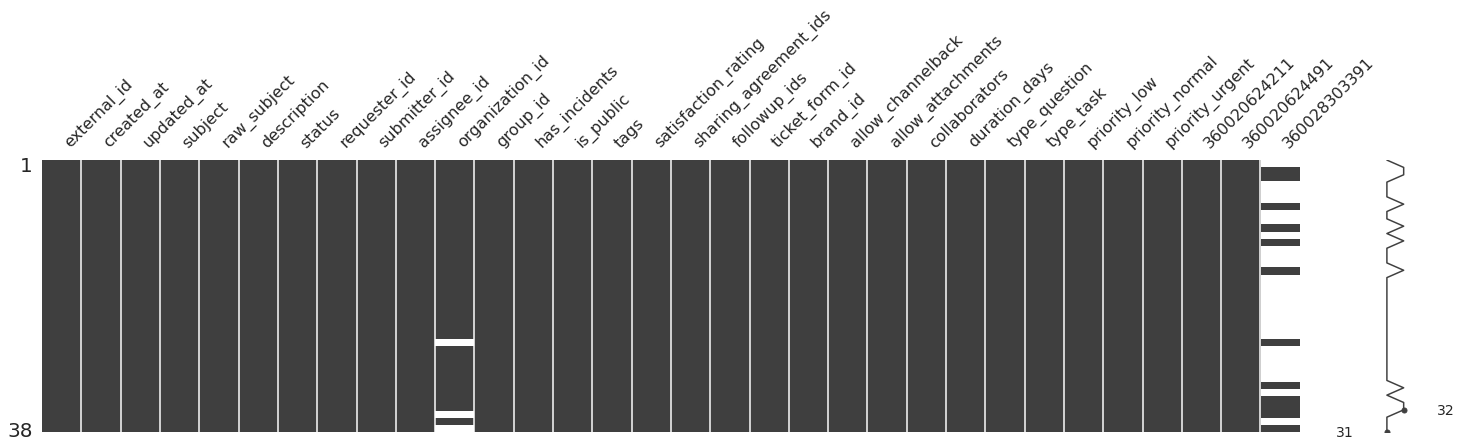

In [72]:
# Visualizar novamente os missing

msno.matrix(x_train, figsize=(25,5));

In [74]:
x_train.head()

,external_id,created_at,updated_at,subject,raw_subject,description,status,requester_id,submitter_id,assignee_id,organization_id,group_id,has_incidents,is_public,tags,satisfaction_rating,sharing_agreement_ids,followup_ids,ticket_form_id,brand_id,allow_channelback,allow_attachments,collaborators,duration_days,type_question,type_task,priority_low,priority_normal,priority_urgent,360020624211,360020624491,360028303391
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
210725,0,2019-12-19,2020-11-27,Pedidos Multiseller sendo cancelados idenvidam...,Pedidos Multiseller sendo cancelados idenvidam...,"Boa noite, meninas!!\n\nTudo bem?\n\n\nEstamos...",closed,378304820672,378304820672,3.856002e+11,4.280584e+07,360005779912,False,True,14,offered,[],[],148248,144968,False,True,7,344,1,0,0,0,0,xp_post_purchase__oms,[resources_used__zendesk],None
177936,0,2019-08-06,2020-10-20,Alterações manuais no Estoque através do Admin...,Alterações manuais no Estoque através do Admin...,"Olá,\n\nAlterações manuais no Estoque através ...",closed,8958433768,8958433768,1.107927e+09,3.601459e+11,360008823572,False,True,21,offered,[],[],148248,144968,False,True,4,441,0,0,0,0,1,xp_merch__catalog__catalog_indexer,[resources_used__xp_issue],31
162875,1,2019-05-29,2020-12-28,Ordenação de produtos por 'Maior Preço' e 'Men...,Ordenação de produtos por 'Maior Preço' e 'Men...,Quando ordenamos a prateleira com a opção 'Mai...,hold,8958433768,8958433768,3.859638e+11,3.601459e+11,360008823572,False,True,21,unoffered,[],[],148248,144968,False,True,1,579,0,0,0,0,0,xp_merch__catalog__catalog_indexer,[resources_used__xp_issue],28
185822,0,2019-09-09,2020-10-07,Nome da Imagem,Nome da Imagem,"Bom dia, tudo bem?\nNotamos que, ao aceitar os...",closed,380202518212,380202518212,3.793557e+11,3.601100e+11,360008834111,False,True,16,offered,[],[],148248,144968,False,True,2,394,1,0,0,0,0,xp_channels__adapter__catalog_integration,[resources_used__someone_knowledge_cx],None
200744,0,2019-11-07,2020-09-29,Problema com Login com Google no Admin,Problema com Login com Google no Admin,"Fala pessoal, tudo bem?\n\nVou precisar de uma...",closed,114303291752,114303291752,3.812780e+11,1.411848e+10,360011294952,False,True,17,offered,[],[],148248,144968,False,True,0,327,0,1,0,1,0,xp_identity__vtex_id,[resources_used__my_own_knowledge],None
